/home/anirudhnihalani/.conda/envs/tvb/lib/python2.7/site-packages/tvb-1.5.4-py2.7-linux-x86_64.egg/tvb/simulator/lab.py:46: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/anirudhnihalani/.conda/envs/tvb/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/anirudhnihalani/.conda/envs/tvb/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/anirudhnihalani/.conda/envs/tvb/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/anirudhnihalani/.conda/envs/tvb/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_insta

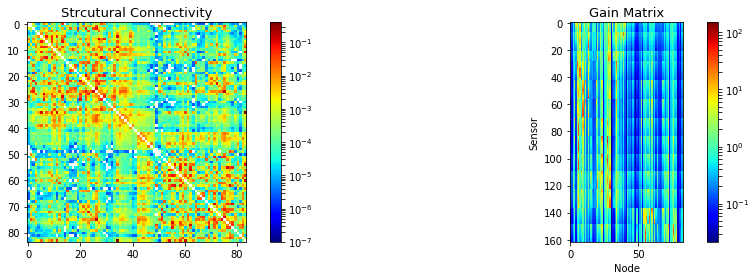

In [1]:
%matplotlib inline
from tvb.simulator.lab import *
import os.path
import matplotlib.pyplot as pyplt
import matplotlib.gridspec as gridspec
from matplotlib import colors, cm
import time
import scipy.signal as sig 
import scipy.spatial.distance as dists
import numpy as np
import time
from scipy.optimize import fsolve
import os

def get_equilibrium(model, init):
    nvars = len(model.state_variables)
    cvars = len(model.cvar)

    def func(x):
        fx = model.dfun(x.reshape((nvars, 1, 1)),
                        np.zeros((cvars, 1, 1)))
        return fx.flatten()

    x = fsolve(func, init)
    return x

rootDir = '/home/anirudhnihalani/vep.stan'
results_dir = os.path.join(rootDir, 'results/exp9')
! mkdir -p {results_dir}
! mkdir -p {results_dir}/logs
! mkdir -p {results_dir}/figures

# # ROIs chosen for generating synthetic data
# chsnAreas = np.array([27,20,58,18,61])

con = connectivity.Connectivity.from_file(os.path.join(rootDir,"data/CJ/connectivity.zip"))
con.speed = np.inf
# normalize
con.weights = con.weights/np.max(con.weights)
con.weights[np.diag_indices(con.weights.shape[0])] = 0
num_regions = len(con.region_labels)
con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources

# Create connectivity object for the chosen ROIs
# conNew = connectivity.Connectivity() 
# conNew.weights = con.weights[:,chsnAreas][chsnAreas,:]
# conNew.tract_lengths = con.tract_lengths[:,chsnAreas][chsnAreas,:]
# conNew.centres = con.centres[chsnAreas]
# conNew.region_labels = np.array([con.region_labels[i] for i in chsnAreas]) 
# conNew.speed = con.speed 
# conNew.cortical = np.ones(len(chsnAreas),dtype=bool)
# num_regions = len(chsnAreas)
gain_mat = np.loadtxt(os.path.join(rootDir,'data/CJ/gain_inv-square.txt'))

pyplt.figure(figsize=[15,4])
pyplt.subplot(121)
norm = colors.LogNorm(1e-7, con.weights.max())
im = pyplt.imshow(con.weights,norm=norm,cmap=cm.jet)
pyplt.colorbar(im, fraction=0.046, pad=0.04)
pyplt.gca().set_title('Strcutural Connectivity', fontsize=13.0)
pyplt.subplot(122)
norm = colors.LogNorm(gain_mat.min(), gain_mat.max())
im = pyplt.imshow(gain_mat,norm=norm,cmap=cm.jet)
pyplt.colorbar(im, fraction=0.046, pad=0.04)
pyplt.gca().set_title('Gain Matrix', fontsize=13.0)
pyplt.xlabel('Node')
pyplt.ylabel('Sensor')
pyplt.tight_layout()
pyplt.savefig(os.path.join(results_dir,'figures/network.png'))
np.savez(os.path.join(results_dir,'network.npz'),SC=con.weights,gain_mat=gain_mat)

In [9]:
epileptors = models.Epileptor(variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'])
epileptors.r = 1.0/2857
epileptors.Ks = np.ones(num_regions)*(-1.0)*5.0
epileptors.tt = 1.0
simLen = 10*1000 # simulation length in milliseconds

# Patient specific modifications
ez = [6,34] 
pz = [22,13,9,27]

noiseON = True
epileptors.x0 = np.ones(num_regions)*-2.5

epileptors.x0[ez] = -1.8
epileptors.x0[pz] = -2.2

coupl = coupling.Difference(a=1.)

nsf = 1.0 # noise scaling factor
# hiss = noise.Additive(nsig = nsf*np.array([0.01, 0.01, 0., 0.00015, 0.00015, 0.]))
hiss = noise.Additive(nsig = nsf*np.array([0.01, 0.01, 0., 0.00015, 0.00015, 0.]))
if(noiseON):
  heunint = integrators.HeunStochastic(dt=0.04, noise=hiss)
else:
  heunint = integrators.HeunDeterministic(dt=0.04)


#mon_raw = monitors.Raw()
mon_tavg = monitors.TemporalAverage(period=1.0)
# mon_SEEG = monitors.iEEG.from_file(sensors_fname=os.path.join(rootDir, "data/CJ/seeg.txt"),
#                                     projection_fname=os.path.join(rootDir, "data/CJ/gain_inv-square.txt"),
#                                     period=1.0,
#                                     variables_of_interest=[6])
# num_contacts = mon_SEEG.sensors.labels.size



# Find a fixed point to initialize the epileptor in a stable state
epileptor_equil = models.Epileptor()
epileptor_equil.x0 = -2.3
#init_cond = np.array([0, -5, 3, 0, 0, 0])
init_cond = get_equilibrium(epileptor_equil, np.array([0.0, 0.0, 3.0, -1.0, 1.0, 0.0]))
init_cond_reshaped = np.repeat(init_cond, num_regions).reshape((1, len(init_cond), num_regions, 1))
sim = simulator.Simulator(model=epileptors,
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          conduction_speed=np.inf,
                          integrator=heunint,
                          monitors=[mon_tavg])

sim.configure()

[(ttavg, tavg)] = sim.run(simulation_length=simLen)
srcSig = tavg[:,0,:,0]
#  # Normalize the time series to have nice plots
# tavgn = (srcSig - np.min(srcSig,1)[:,np.newaxis])/(np.max(srcSig, 1) - np.min(srcSig, 1))[:,np.newaxis]
# Compute the seeg from the source signals
seeg = np.dot(gain_mat,srcSig.T)
# Save data for data fitting
savePathTS=os.path.join(results_dir,"syn_tvb_ez=%s_pz=%s.npz"%('-'.join([str(el) for el in ez]),'-'.join([str(el) for el in pz])))
np.savez(savePathTS, time_steps=ttavg, src_sig=srcSig, seeg=seeg, x0=epileptors.x0)

In [10]:
import numpy as np
syn_data = np.load('results/exp9/syn_tvb_ez=6-34_pz=22-13-9-27.npz')
# print('%s,%s'%(np.shape(syn_data['src_sig']), np.shape(syn_data['seeg'])))
num_regions = syn_data['src_sig'].shape[1]
nChannels = syn_data['seeg'].shape[0]

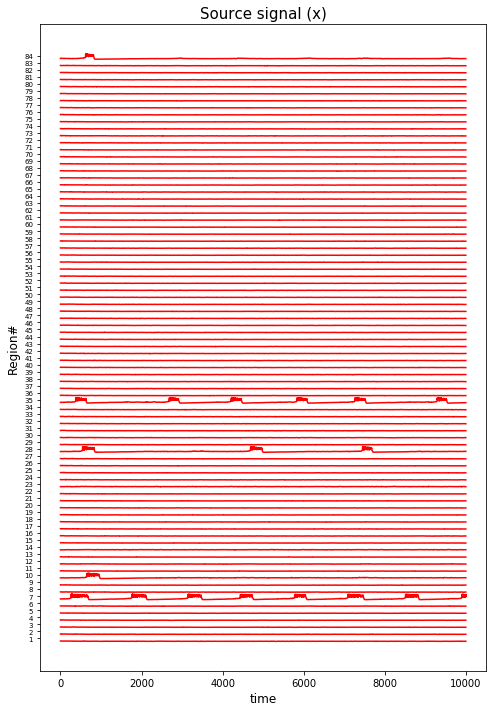

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot source time series
indf = 0
indt = -1

regf = 0
regt = num_regions
plt.figure(figsize=(7,10))
plt.plot(ttavg, srcSig/4 + np.r_[regf:regt], 'r')
plt.yticks(np.r_[regf:regt], np.r_[regf:regt]+1,fontsize=7.0)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.tight_layout()

plt.savefig(os.path.join(results_dir,"figures/src_signals.png"))

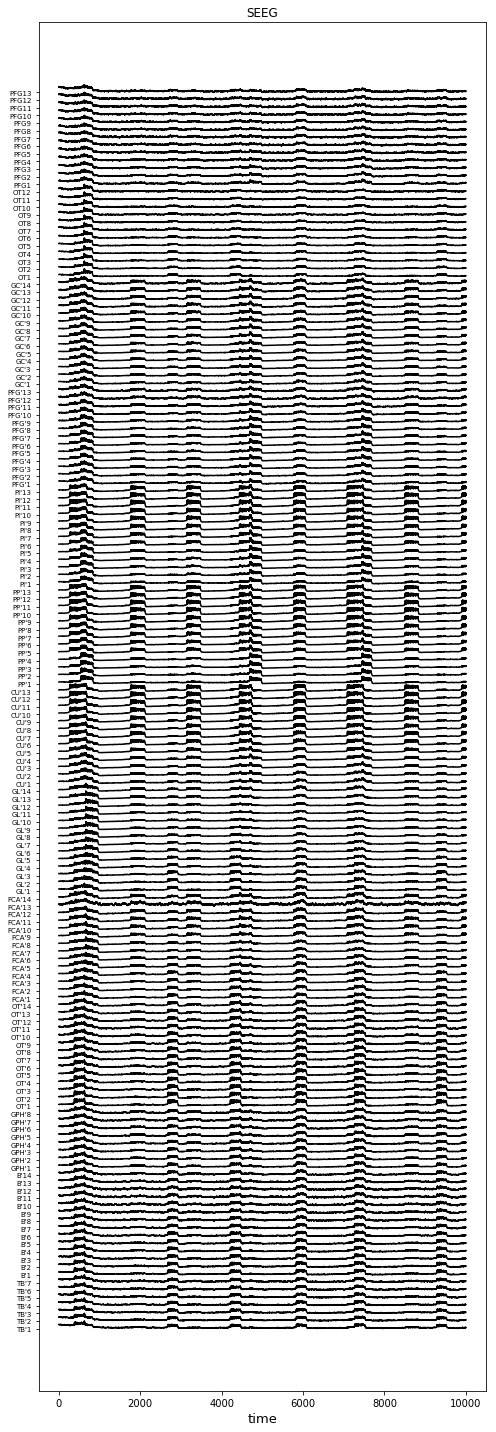

In [20]:
seegn = (seeg - np.min(seeg,1)[:,np.newaxis]) / (np.max(seeg,1) - np.min(seeg,1))[:,np.newaxis]
#  seegn = seegn - np.mean(seegn)
#  b, a = sig.butter(2, 0.1, btype='highpass', output='ba')
#  seegf = sig.filtfilt(B, A, seegn)
#  seegf = np.zeros(seegn.shape)
#  for i in range(num_contacts):
#      seegf[:, 0, i, 0] = sig.filtfilt(b, a, seeg[:, 0, i, 0])


# Plot the seeg time series
nChannels = np.shape(gain_mat)[0]
fd = open('data/CJ/seeg.txt')
snsrLabels = [line.split(' ')[0] for line in fd]
fd.close()

plt.figure(figsize=(7,20))
plt.plot(ttavg[:], seegn.T + np.r_[0:nChannels],'k')
plt.xlabel('time',fontsize=13.0)
plt.yticks(np.r_[0:nChannels], snsrLabels, fontsize=7.0)
plt.title("SEEG")
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"figures/seeg.png"))